# Automated Essay Scoring

## 1. Business Understanding

Teaching students how to write well is essential since it enables them to convey their ideas, offer arguments that persuade others and ultimately to succeed in their personal and academic endevours [(McNamara, 2015)](https://www.sciencedirect.com/science/article/abs/pii/S1075293514000427). As such, writing exercises such as essays are a powerful tool for evaluating and preparing students in this area. However, grading essays manually is time-consuming and expensive for states. As a result, educational institutions opt in for multiple-choice standardized tests instead . Thus, developing high-fidelity automated essay scoring tools is of utmost importance.

## 2. Exploratory Data Analysis

In [154]:
%reset

In [202]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import spacy
import sys
sys.path.append('./src')

import feature_engineering, preprocessing, visualizations, post_processing
from feature_engineering import extract_features_bulk
from preprocessing import normalize_scores
from post_processing import denormalize_scores
from visualizations import compare_raters

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, cohen_kappa_score
# from sklearn.preprocessing import StandardScaler

In [156]:
importlib.reload(feature_engineering)
importlib.reload(preprocessing)
importlib.reload(visualizations)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\setar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'visualizations' from 'd:\\DS_Flat_Iron\\Phase_V\\project\\education_early_intervention\\./src\\visualizations.py'>

In [157]:
df = pd.read_csv('./data/training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1', index_col=0)
df.head(2)

,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
essay_id,,,,,,,,,,,,,,,,,,,,,
1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
df.isna().sum()

essay_set             0
essay                 0
rater1_domain1        0
rater2_domain1        0
rater3_domain1    12848
domain1_score         0
rater1_domain2    11176
rater2_domain2    11176
domain2_score     11176
rater1_trait1     10684
rater1_trait2     10684
rater1_trait3     10684
rater1_trait4     10684
rater1_trait5     12253
rater1_trait6     12253
rater2_trait1     10684
rater2_trait2     10684
rater2_trait3     10684
rater2_trait4     10684
rater2_trait5     12253
rater2_trait6     12253
rater3_trait1     12848
rater3_trait2     12848
rater3_trait3     12848
rater3_trait4     12848
rater3_trait5     12848
rater3_trait6     12848
dtype: int64

In [159]:
cols_to_keep = ['essay_set', 'essay', 'rater1_domain1', 'rater2_domain1', 'domain1_score']
df = df[cols_to_keep]
df.rename(columns={'rater1_domain1':'rater1_score','rater2_domain1':'rater2_score', 'domain1_score':'final_score'}, inplace=True)
df.head()

,essay_set,essay,rater1_score,rater2_score,final_score
essay_id,,,,,
1,1,"Dear local newspaper, I think effects computer...",4,4,8
2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9
3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7
4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10
5,1,"Dear @LOCATION1, I know having computers has a...",4,4,8


### 2.1. Distribution of scores and agreement of human raters
Each set of essays has its own score range (outlined in the code cell below). In order to visualize the distribution of scores for all essays and later on use them as one single training set, we need to normalize the scores. We choose to normalize all scores to the range 0-10 through a linear transformation. 

In [160]:
# min-max range for each essay set
num_essay_sets = len(df['essay_set'].unique())
rubric_range = {
    1: {'rater_min': 1, 'rater_max': 6, 'final_min': 2, 'final_max': 12},
    2: {'rater_min': 1, 'rater_max': 6, 'final_min': 1, 'final_max': 6},
    3: {'rater_min': 0, 'rater_max': 3, 'final_min': 0, 'final_max': 3},
    4: {'rater_min': 0, 'rater_max': 3, 'final_min': 0, 'final_max': 3},
    5: {'rater_min': 0, 'rater_max': 4, 'final_min': 0, 'final_max': 4},
    6: {'rater_min': 0, 'rater_max': 4, 'final_min': 0, 'final_max': 4},
    7: {'rater_min': 0, 'rater_max': 15, 'final_min': 0, 'final_max': 30},
    8: {'rater_min': 0, 'rater_max': 30, 'final_min': 0, 'final_max': 60}
}

In [161]:
for i in range(num_essay_sets):
    mask = df['essay_set'] == i+1
    df.loc[mask, 'rater1_score_norm'] = df.loc[mask].apply(normalize_scores, axis=1, 
                                                            args=('rater1_score', rubric_range[i+1]['rater_min'], rubric_range[i+1]['rater_max']))
    df.loc[mask, 'rater2_score_norm'] = df.loc[mask].apply(normalize_scores, axis=1, 
                                                            args=('rater2_score', rubric_range[i+1]['rater_min'], rubric_range[i+1]['rater_max']))
    df.loc[mask, 'final_score_norm'] = df.loc[mask].apply(normalize_scores, axis=1, 
                                                            args=('final_score', rubric_range[i+1]['final_min'], rubric_range[i+1]['final_max']))
df.head()

,essay_set,essay,rater1_score,rater2_score,final_score,rater1_score_norm,rater2_score_norm,final_score_norm
essay_id,,,,,,,,
1,1,"Dear local newspaper, I think effects computer...",4,4,8,6.0,6.0,6.0
2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9,8.0,6.0,7.0
3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7,6.0,4.0,5.0
4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10,8.0,8.0,8.0
5,1,"Dear @LOCATION1, I know having computers has a...",4,4,8,6.0,6.0,6.0


**Inter-Rater Reliability (IRR):**  
IRR refers to how well raters agree given the same input data. Since we will evaluate the machine learning models based on how well they agree with human raters, it's important to have a benchmark for how well human raters agree among themselves (Ghanta, 2019). In this section, we visualize the agreement between raters 1 and 2 for individual essay sets, as well as all essays. 

Note that normalization of scores and binning them can affect Cohen's Kappa in unexpected ways. Therefore, the Cohen's Kappa is determined for each essay set individually, using the original rubric range. In the end, the mean over all coefficients is used as the average agreement score between human raters. 

Average of Cohen's Kappa is: 0.75
Standard deviation of Cohen's Kappa is: 0.07


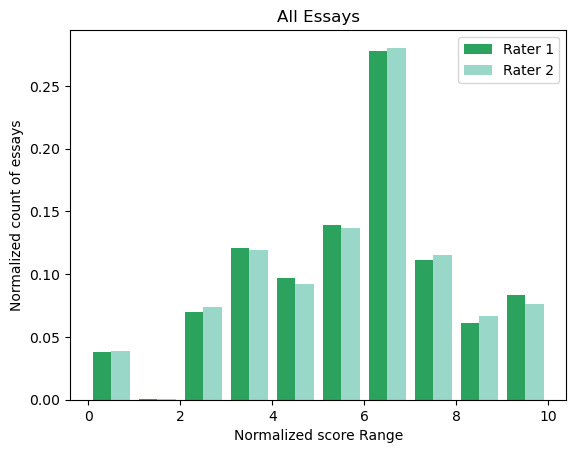

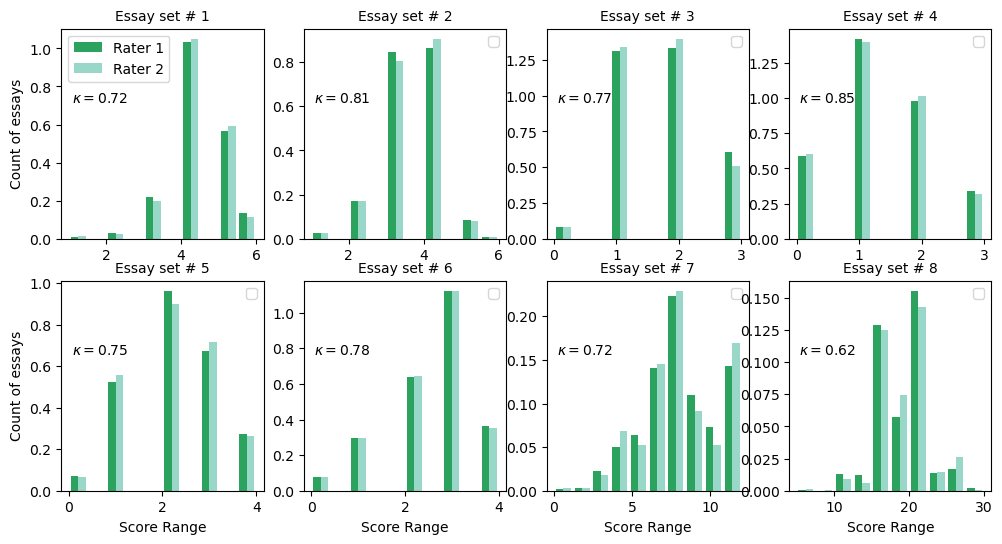

In [162]:
compare_raters(df)

As it can be seen, the average of Kohen's Kappa across all 8 sets of essays is 0.75 $\pm$ 0.07. This indicates substantial agreement among human raters. This baseline is important since we would like to compare the agreement between a human rater with the automated scoring system. 

In [163]:
df[df['essay_set']==1].shape

(1783, 8)

In [164]:
df.shape

(12976, 8)

### 2.1. Feature Engineering


In [165]:
df_features = extract_features_bulk(list(df['essay']))

In [166]:
df_features['essay_set'] = df.reset_index()['essay_set']
df_features['target'] = df.reset_index()['final_score_norm']
df_features['final_score'] = df.reset_index()['final_score']

In [167]:
df['final_score_norm'].isna().sum()

0

In [168]:
df_features.head()

,num_words,num_sentences,avg_sentence_length,std_sentence_length,avg_syllable_count,std_syllable_count,avg_letter_count,std_letter_count,flesch_reading_ease,flesh_kincaid_grade,...,num_stopwords,num_pronouns,num_verbs,avg_tree_depth,avg_concreteness,num_misspelled,lsa_overlap_avg,essay_set,target,final_score
0,340,16,24.687500,15.369748,1.258824,0.577921,4.182353,2.068655,65.56,9.7,...,0.532353,0.141176,0.147059,3.614706,2.366471,0.026471,0.725964,1,6.0,8
1,410,20,22.800000,13.065020,1.375610,0.716819,4.290244,2.324769,67.08,9.1,...,0.475610,0.121951,0.168293,3.775610,2.231732,0.031707,0.545503,1,7.0,9
2,272,15,20.400000,13.329881,1.400735,0.747246,4.330882,2.330783,59.74,9.9,...,0.525735,0.095588,0.147059,3.459559,2.092757,0.003676,0.608161,1,5.0,7
3,485,27,21.333333,12.612570,1.468041,0.806424,4.680412,2.463563,51.78,10.9,...,0.459794,0.065979,0.148454,3.206186,2.097278,0.045361,0.784982,1,8.0,10
4,463,30,17.266667,7.153168,1.406048,0.761155,4.343413,2.306774,64.20,8.2,...,0.520518,0.088553,0.129590,2.645788,2.097473,0.019438,0.700912,1,6.0,8


## 3. Machine Learning Model

### Random Forest Regressor

In [191]:
# Custom scoring function for RandomizedSearchCV
def cohen_kappa_scorer(estimator, X, y, essay_set):
    y_pred = estimator.predict(X)

    y_pred_denorm = np.zeros_like(y)
    y_true_denorm = np.zeros_like(y)

    for i in range(len(y)):
        min_range = rubric_range[essay_set[i]]['final_min']
        max_range = rubric_range[essay_set[i]]['final_max']

        y_pred_denorm[i] = denormalize_scores(y_pred[i], min_range, max_range)
        y_true_denorm[i] = denormalize_scores(y[i], min_range, max_range)

    # Handle edge case where model fails and returns constant predictions
    if np.std(y_pred_denorm) == 0:
        return -1  # Arbitrary low score for failed models

    score = cohen_kappa_score(
        np.round(y_true_denorm), np.round(y_pred_denorm), weights='quadratic'
    )

    return score

In [180]:
df_features.head()

,num_words,num_sentences,avg_sentence_length,std_sentence_length,avg_syllable_count,std_syllable_count,avg_letter_count,std_letter_count,flesch_reading_ease,flesh_kincaid_grade,...,num_stopwords,num_pronouns,num_verbs,avg_tree_depth,avg_concreteness,num_misspelled,lsa_overlap_avg,essay_set,target,final_score
0,340,16,24.687500,15.369748,1.258824,0.577921,4.182353,2.068655,65.56,9.7,...,0.532353,0.141176,0.147059,3.614706,2.366471,0.026471,0.725964,1,6.0,8
1,410,20,22.800000,13.065020,1.375610,0.716819,4.290244,2.324769,67.08,9.1,...,0.475610,0.121951,0.168293,3.775610,2.231732,0.031707,0.545503,1,7.0,9
2,272,15,20.400000,13.329881,1.400735,0.747246,4.330882,2.330783,59.74,9.9,...,0.525735,0.095588,0.147059,3.459559,2.092757,0.003676,0.608161,1,5.0,7
3,485,27,21.333333,12.612570,1.468041,0.806424,4.680412,2.463563,51.78,10.9,...,0.459794,0.065979,0.148454,3.206186,2.097278,0.045361,0.784982,1,8.0,10
4,463,30,17.266667,7.153168,1.406048,0.761155,4.343413,2.306774,64.20,8.2,...,0.520518,0.088553,0.129590,2.645788,2.097473,0.019438,0.700912,1,6.0,8


In [181]:
# # Load your features and labels
# X = df_features[df_features['essay_set']==1].drop(columns=['target', 'final_score']).values
# y = df_features[df_features['essay_set']==1]['target'].values

# # Append essay set to X
# # X = np.hstack([X, essay_set])

# # Split train-test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# rf = RandomForestRegressor()
# rf.fit(X_train,y_train)
# cohen_kappa_scorer(rf,X_train,y_train)

In [ ]:
# Load your features and labels
X = df_features[df_features['essay_set']==1].drop(columns=['target', 'final_score']).values
y = df_features[df_features['essay_set']==1]['target'].values
essay_set = df_features[df_features['essay_set']==1]['essay_set'].values
# Append essay set to X
# X = np.hstack([X, essay_set])

# Split train-test
X_train, X_test, y_train, y_test, es_train, es_test = train_test_split(X, y, essay_set, test_size=0.2, random_state=42)

# Random Forest + Hyperparameter tuning
rf = RandomForestRegressor()

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=2, cv=3, verbose=1,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Best estimator
best_model = random_search.best_estimator_

# Cross-validation on the best model
cv = KFold(n_splits=3, shuffle=True, random_state=42)
cv_mse = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_r2 = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='r2')

cv_mse = -np.mean(cv_mse)
cv_r2 = np.mean(cv_r2)

print(f"Cross-validated MSE: {cv_mse:.2f}")
print(f"Cross-validated R2: {cv_r2:.2f}")

# Test set prediction
y_pred = best_model.predict(X_test)

# Denormalize test predictions
y_pred_denorm = np.zeros_like(y_test)
y_test_denorm = np.zeros_like(y_test)

for i in range(len(y_test)):
    min_range = rubric_range[es_test[i]]['final_min']
    max_range = rubric_range[es_test[i]]['final_max']
    y_pred_denorm[i] = denormalize_scores(y_pred[i], min_range, max_range)
    y_test_denorm[i] = denormalize_scores(y_test[i], min_range, max_range)

# Test Cohen's kappa
test_kappa = cohen_kappa_score(
    np.round(y_test_denorm), np.round(y_pred_denorm), weights='quadratic'
)
print(f"Test Kappa: {test_kappa:.2f}")




Fitting 3 folds for each of 2 candidates, totalling 6 fits
Cross-validated MSE: 0.69
Cross-validated R2: 0.71
Test Kappa: 0.84


In [138]:
# Best estimator
best_model = random_search.best_estimator_

# Cross-validated kappa
cv_kappa = random_search.best_score_
print(f"Best Cross-Validated Kappa: {cv_kappa:.4f}")

# # Test set prediction
# y_pred = best_model.predict(X_test)

# # Denormalize test predictions
# y_pred_denorm = np.zeros_like(y_test)
# y_test_denorm = np.zeros_like(y_test)
# for i in range(len(y_test)):
#     min_range = rubric_range[essay_set[i][0]]['final_min']
#     max_range = rubric_range[essay_set[i][0]]['final_max']
#     y_pred_denorm[i] = denormalize_scores(y_pred[i], min_range, max_range)
#     y_test_denorm[i] = denormalize_scores(y_test[i], min_range, max_range)

# # Test Cohen's kappa
# test_kappa = cohen_kappa_score(np.round(y_pred_denorm), np.round(y_test_denorm), weights='quadratic')
# print(f"Test Kappa: {test_kappa:.4f}")

Best Cross-Validated Kappa: nan


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Test MSE: 0.6124
Test R²: 0.7310


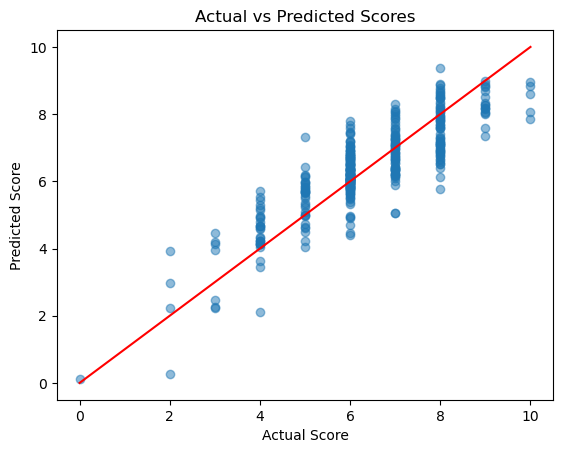

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'score' is the target variable
X = df_features[df_features['essay_set']==1].drop(columns=['target','essay_set', 'final_score'])
y = df_features[df_features['essay_set']==1]['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
rf = RandomForestRegressor()

# Define the hyperparameter grid
param_distributions = {
    'n_estimators': [50, 100, 300],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=100,  # Number of random combinations to try
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Predict and calculate Cohen's kappa
y_pred = best_model.predict(X_test)
# Evaluate on the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test MSE: {mse:.4f}')
print(f'Test R²: {r2:.4f}')

# Plot results
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Actual vs Predicted Scores')
plt.show()

In [ ]:
y_pred_denormalized = post_processing.denormalize_scores(y_pred, 2, 12)
cohen_kappa_test = cohen_kappa_score(np.round(y_pred_denormalized), np.round(post_processing.denormalize_scores(y_test,2, 12)), weights='quadratic')


0.8341924333214049

In [15]:
# extract features for each essay
# establish the dataframe
# include the scores in the dataframe as the target
# train-test split
# scale X
# fit-transform the regression model
# cross-validate, evaluate test scores